In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [2]:
rho_oceanic = 3.0e9 #kg/km^3
rho_contin = 2.8e9 #kg/km^3 [courtesy of www.iupui.edu Indiana University website]
plate_length=2.9e2
A = 1e-17 #A is some constant I made up to make the tectonic plate more resistant to breaking.
#plate_interval = 1e11

#Equation for Moment Release [Taken from HW 10 PDF]
from numba import jit
def calc_moment_release(magnitude):
    E = np.absolute(((2/3)*np.log10(magnitude) - 10.7)*10**(-7))
    return E.astype(np.float64)
#Generate random cracks
def gen_crack(lengthofx):
    number_of_cracks = np.random.randint(1,100)
    xposition_cracks = np.array([],dtype=int)
    a = np.array([],dtype=np.float64)
    i=0
    while i < number_of_cracks:
        xposition_cracks = np.append(xposition_cracks, np.random.randint(1,lengthofx-1))
        a = np.append(a,0.1 * np.random.randint(0,10)) #start depth of crack
        i+=1
    return xposition_cracks, a
def force(crack_location,crack_depth):
    global rho_oceanic, rho_contin,plate_length,A
    earthquake_energy=0.0
    grav_energy=0.0
    #Gravitational Force Lever: Calculated by applying the total gravitational force on the
                                #plate from one side of the crack times the distance from the
                                #crack to the edge of the plate. This will only apply to the
                                #side of the plate that is under the continental crust, because
                                #while gravity acts everywhere, the force of gravity should be
                                #negated by the buoyancy force from the mantle. As a result,
                                #the net force due to gravitational forces on the side of the 
                                #plate not under the Acapulcos is zero.

    grav_energy = np.float64(A*((plate_length-crack_location))*60*rho_contin*10)
    
    #Earthquake Force: Assume that the force is pulling the plate apart at the crack. This should
                        #not be too unreasonable because the energy is propagated through in the 
                        #form of longitudinal and transverse waves. The moment release gives us the
                        #energy released, so I do not have to worry about going from force to energy;
                        #I use the moment release function I defined earlier. This takes into 
                        #account that there are regularly small earthquakes occuring that would
                        #impart energy to the plate. I will simulate this using a random number 
                        #generator between 1 and 5, since larger earthquakes are less frequent
                        #and are due to major events along fault lines.
    number_earthquakes = np.random.randint(0,2) #Is there an earthquake? 0 for no, 1 for yes
    if number_earthquakes==0:
        earthquake_energy=0
    if number_earthquakes==1:
        magnitude = np.random.random()+np.random.randint(1,9)
        earthquake_energy=calc_moment_release(magnitude)*1.0
    
    #Resistance to Forces: given by fracture toughness, which is in J. 
    stress = (grav_energy)+(earthquake_energy)
    poisson_ratio = 0.25 #taken from agupubs.onlinelibrary. This should be the average of
                        #of the poisson ratios for the upper through lower crust.
    stiffness = (1-poisson_ratio**2)
    resistant_force = grav_energy*1.0*(stiffness)/np.sqrt(np.pi*crack_depth)
    if resistant_force >= stress:
        total_force = 0
    if resistant_force < stress:
        total_force = np.float64((grav_energy-resistant_force)*(plate_length-crack_location)*1.0+earthquake_energy)

    return total_force
def crack_propagation(x,y,ystandard,t_in_seconds):
    global rho_oceanic, rho_continental, plate_length
    np.seterr(all='raise')
    #top layer will move with acceleration*time due to non-negated forces, bottom layer
    #will move together with acceleration*time due to non-negated forces. However because
    #the bottom layer is compressed, and we do not expect any fracture to occur. As a result,
    #y-position of the crack and above, the new crack will be propagated downward, while the
    #previously existing region of the crack will spread outward, if the forces are larger 
    #than the resistance.
    crack_indices = np.where(y<ystandard)[0]
    crack_location = x[crack_indices]
    
    for i in crack_indices:
        crack_indices = np.where(y<ystandard)[0]
        crack_location = x[crack_indices]
        crack_depth = ystandard-y[i]
        total_force = force(x[i],crack_depth)
        #print(i,': force:',total_force)
        velocity = total_force
        #print(i,': velocity:',velocity)
        y[i] = y[i] - velocity*(crack_depth/np.sqrt(crack_depth**2+(plate_length-x[i])**2))
        #New Crack?
        crack_check=np.random.randint(0,8)
        if crack_check>1 and i > 0 and i < (plate_length-1):
            a = np.random.random()*np.random.randint(1,10)
            direc = np.random.randint(-1,2)
            y[i+direc]=y[i+direc]-(a+crack_depth)
        #x[i-1] = x[i-1] - velocity*((plate_length-x[i-1])/np.sqrt(crack_depth**2+(plate_length-x[i-1])**2))
        #x[i] = x[i] + velocity*((plate_length-x[i])/np.sqrt(crack_depth**2+(plate_length-x[i])**2))
    
    #How much does part of the plate move down? It depends on the difference between the 
    #downward force and the resistance to breakage from the plate and the time of the simulation
    #Downward velocity is the sine of the angle with respect to the horizontal. Horizontal velocity
    #is the cosine of the angle with respect to the horizontal.
    return x,y
    
def plate_move(acapulcos_pos,fraction_of_year):
    #Take into account that the plates are moving closer a few centimeters each year,
    #so the Acapulcos plate should be moving over the Cocos plate by a few centimeters each year,
    #or 6cm/365. I am choosing 6 cm as the rate of movement for the plates because it sounds vaguely familiar
    #and is on the correct order of magnitude
    cont_drift = acapulcos_pos+(.06*fraction_of_year)
    return cont_drift

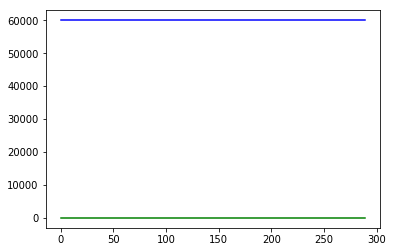

In [3]:
acapulcos_start = 0.5*plate_length*1.0
cocos_thickness = 60000 #meters
acapulcos_pos = np.arange(acapulcos_start,plate_length)
yx2 = np.ones((acapulcos_pos.size))*cocos_thickness
x = np.arange(0,plate_length,dtype=np.float64)

y1 = np.ones((int(plate_length),))*cocos_thickness
y2 = np.zeros((int(plate_length),))*1.0
plt.plot(x,y1,c='b')
plt.plot(x,y2,c='g')
plt.show()

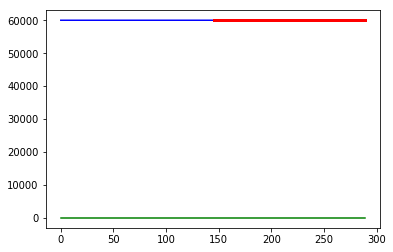

In [4]:
#Initial Conditions
positions,a = gen_crack(len(x))
#print(np.where(x<60)[0])
for i in range(0,len(positions)):
    y1[positions[i]] = y1[positions[i]] - a[i]
plt.plot(x,y1,c='b')
plt.plot(x,y2,c='g')
plt.plot(acapulcos_pos,yx2, c='r',linewidth=3)
#plt.ylim(59999,60001)
plt.show()

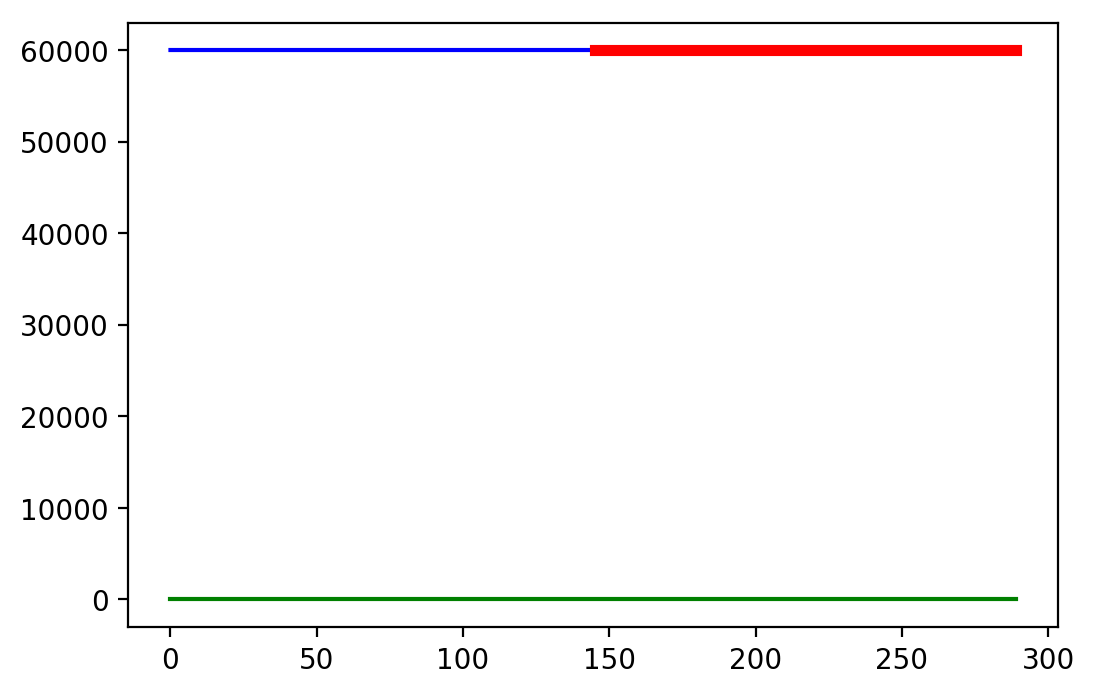

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Plate has Broken


In [5]:
from matplotlib.animation import FFMpegWriter
metadata = dict(title='Breaking the Cocos Plate', artist='Matplotlib')
writer = FFMpegWriter(fps=1, metadata=metadata,bitrate=200000)
fig = plt.figure(dpi=200)
t_max = 21 #days

#plt.plot(y1,c='b')
#plt.plot(y2,c='g')
#plt.plot(acapulcos_pos,yx2, c='r',linewidth=4)
#plt.ylim(59999,60001)
#with writer.saving(fig,"Tang,Cassandra_animation.mp4",dpi=200):
#    for t in range(0,t_max):
#        if np.min(y1)<0:
#            print('Plate has Broken')
#            break
#        acapulcos_pos = plate_move(acapulcos_pos, 1/365)
#        x, y1 = crack_propagation(x,y1,cocos_thickness,86400)
#        plt.draw()
#        plt.pause(0.01)
#        writer.grab_frame()
with writer.saving(fig,"Tang,Cassandra_animation.mp4",dpi=200):
    for t in range(0,t_max):
        if np.min(y1)<0:
            print('Plate has Broken')
            break
        acapulcos_pos = plate_move(acapulcos_pos,1/365)
        x,y1 = crack_propagation(x,y1,cocos_thickness,86400)
        fig.clear()
        ax = fig.gca()
        ax.plot(y1,c='b')
        ax.plot(y2,c='g')
        ax.plot(acapulcos_pos,yx2, c='r',linewidth=4)
        plt.draw()
        plt.pause(0.01)
        writer.grab_frame()
    